In [1]:
import os
import IPython.display as ipd

import librosa
import librosa.display
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import utils
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.callbacks import Callback
from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
DATA_DIR = '../input/cat-meow-classification/dataset/dataset/'
audio_files = os.listdir(DATA_DIR)

In [3]:
# 'F' : 'Waiting For Food', 'I' : 'Isolated in unfamiliar Environment', 'B' : 'Brushing'
emission_context = {'F' : [], 'I' : [], 'B' : []}

# breed (values: MC = Maine Coon; EU: European Shorthair);
breed = {'MC' : [], 'EU' : []}

for file in audio_files:
    split = file.split('_')
    if split[0] in emission_context.keys():
        emission_context.get(split[0]).append(file)
        
    if split[2] in breed.keys():
        breed.get(split[2]).append(file)
        

# EDA
## check the audio
by listening to samples of the sound, visualizing the sound, and making a spectrogram of the sound.
1. Audio of Waiting For Food

In [4]:
wait_food_ex = '/kaggle/input/cat-meow-classification/dataset/dataset/'+ emission_context.get('F')[2]
data , sample_rate = librosa.load(wait_food_ex)
librosa.load(wait_food_ex)
ipd.Audio(wait_food_ex)

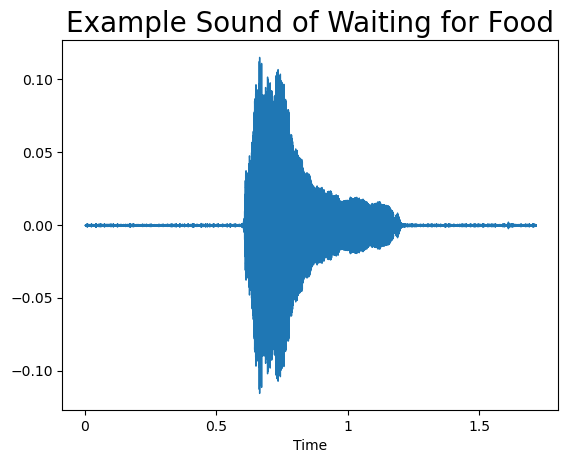

In [5]:
librosa.display.waveshow(data)D
plt.title("Example Sound of Waiting for Food", fontsize = 20);

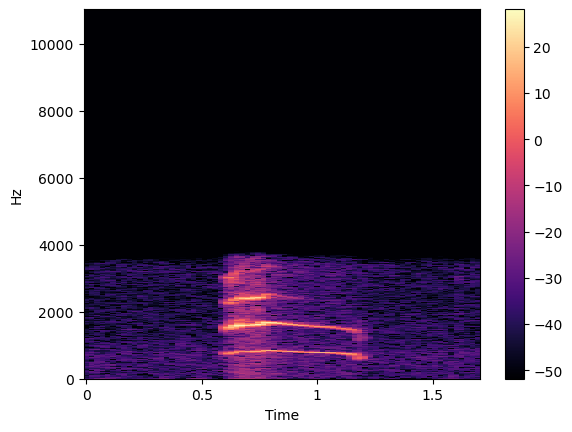

In [6]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()

2. Audio of Isolated in unfamiliar Environment

In [7]:
isolated_ex = '/kaggle/input/cat-meow-classification/dataset/dataset/'+ emission_context.get('I')[0]
data , sample_rate  = librosa.load(isolated_ex)
librosa.load(isolated_ex)
ipd.Audio(isolated_ex)

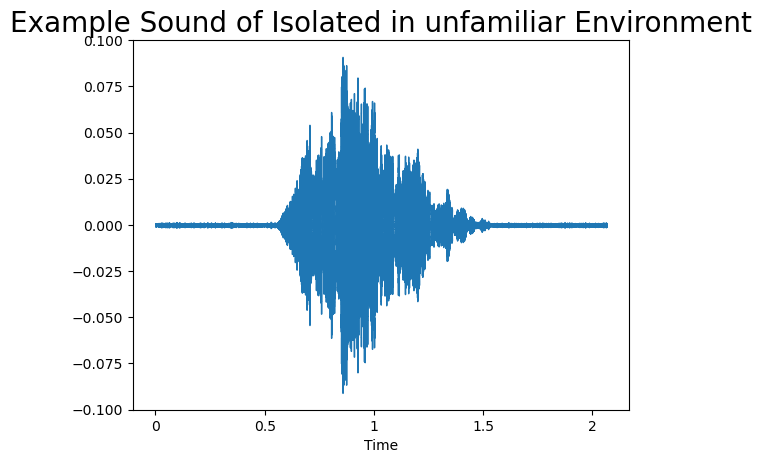

In [8]:
librosa.display.waveshow(data)
plt.title("Example Sound of Isolated in unfamiliar Environment", fontsize = 20);

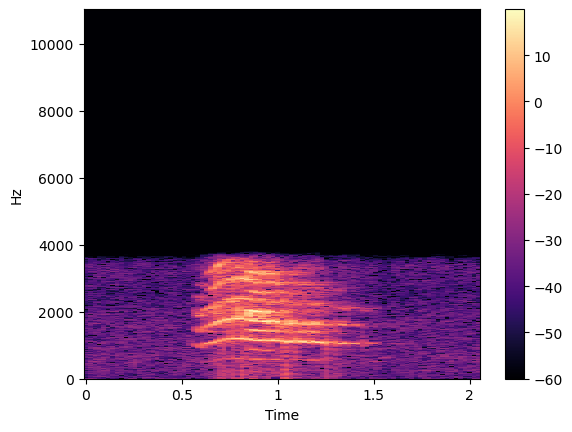

In [9]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()

3. Audio of Brushing

In [10]:
brushing_ex = '/kaggle/input/cat-meow-classification/dataset/dataset/'+ emission_context.get('B')[1]
data , sample_rate  = librosa.load(brushing_ex)
librosa.load(brushing_ex)
ipd.Audio(brushing_ex)

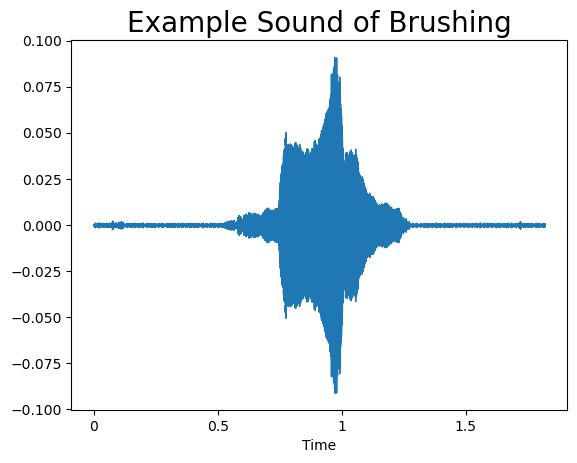

In [11]:
librosa.display.waveshow(data)
plt.title("Example Sound of Brushing", fontsize = 20);

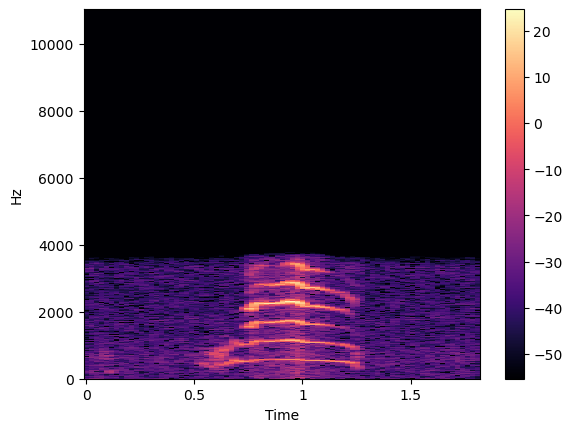

In [12]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()

## Plot based emission context

In [13]:
len_value =[]
for i in emission_context.values():
    len_value.append(len(i))
len_value

[92, 221, 127]

In [14]:
# rename keys of dictionary
emission_context['Waiting For Food'] = emission_context.pop('F')
emission_context['Isolated in unfamiliar Environment'] = emission_context.pop('I')
emission_context['Brushing'] = emission_context.pop('B')

Text(0, 0.5, 'Number of cat sound')

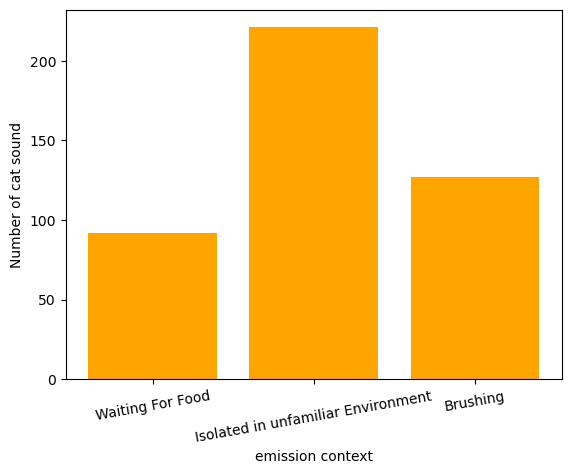

In [15]:
x = emission_context.keys()
y = len_value
plt.bar(x, y, color ='orange')
plt.xticks(rotation=10)
plt.xlabel("emission context")
plt.ylabel("Number of cat sound")

## Plot based breed

Text(0, 0.5, 'Number of cat sound')

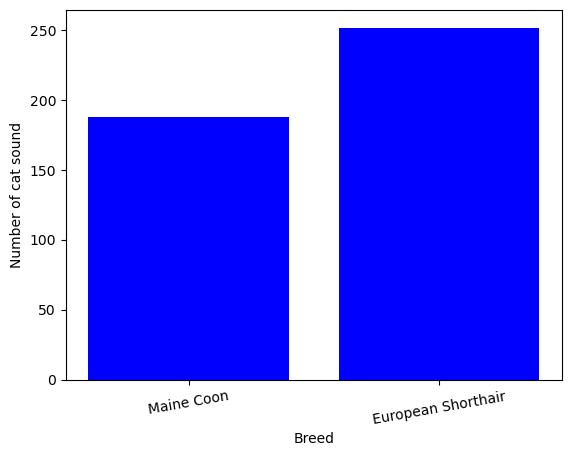

In [16]:
len_value =[]
for i in breed.values():
    len_value.append(len(i))

# rename keys of dictionary
breed['Maine Coon'] = breed.pop('MC')
breed['European Shorthair'] = breed.pop('EU')

x = breed.keys()
y = len_value
plt.bar(x, y, color ='blue')
plt.xticks(rotation=10)
plt.xlabel("Breed")
plt.ylabel("Number of cat sound")

## make all data into one dataframe 

In [17]:
def add_path(list_emission):
    path = []
    for i in range(len(list_emission)):
        path.append('/kaggle/input/cat-meow-classification/dataset/dataset/'+list_emission[i])
    return path


a = add_path(emission_context['Waiting For Food'])
b = add_path(emission_context['Isolated in unfamiliar Environment'])
c = add_path(emission_context['Brushing'])
emission = a+b+c
df = pd.DataFrame(emission, columns=['Emission'])

In [18]:
label_W = np.tile('Waiting For Food',92)
label_I = np.tile('Isolated in unfamiliar Environment',221)
label_B = np.tile('Brushing',127)

Label = np.append(label_W, np.append(label_I, label_B))
df['Label'] = Label

In [19]:
audio_array = []

for i in df['Emission']:
    x, sr = librosa.load(i, sr=44100)
    audio_array.append(x)
    
df['Data Arrays'] = audio_array

In [20]:
df

,Emission,Label,Data Arrays
0,/kaggle/input/cat-meow-classification/dataset/...,Waiting For Food,"[0.00021128784, 0.00010554999, -6.464131e-05, ..."
1,/kaggle/input/cat-meow-classification/dataset/...,Waiting For Food,"[0.00018780564, 0.00026301446, 0.00033463392, ..."
2,/kaggle/input/cat-meow-classification/dataset/...,Waiting For Food,"[-6.461764e-05, -9.359857e-05, -0.000120505974..."
3,/kaggle/input/cat-meow-classification/dataset/...,Waiting For Food,"[0.001972097, 0.0027393007, 0.0034702164, 0.00..."
4,/kaggle/input/cat-meow-classification/dataset/...,Waiting For Food,"[-7.664297e-05, 6.907519e-05, 0.00028343976, 0..."
...,...,...,...
435,/kaggle/input/cat-meow-classification/dataset/...,Brushing,"[0.00021484672, 0.0001701343, 6.5840926e-05, -..."
436,/kaggle/input/cat-meow-classification/dataset/...,Brushing,"[0.00034755818, 0.00032045483, 0.0002236986, 7..."
437,/kaggle/input/cat-meow-classification/dataset/...,Brushing,"[0.0002513592, 0.00035091076, 0.00044699394, 0..."
438,/kaggle/input/cat-meow-classification/dataset/...,Brushing,"[0.00044875345, 0.0003984447, 0.00024237804, 5..."


# Data Augmentation

In [21]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    return librosa.effects.time_stretch(data, rate=0.8)

def pitch(data, sr):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=4)

# Extracting Features

In [22]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [23]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sr=sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [24]:
x = []
y = []
for i in range(len(df)):
    feature=get_features(df['Emission'].iloc[i]);
    for j in feature:
        x.append(j)
        y.append(df['Label'].iloc[i])

In [25]:
le = LabelEncoder()
y = utils.to_categorical(le.fit_transform(y))

## Split Data

In [26]:
x_train, x_test, y_train, y_test = train_test_split(np.array(x), np.array(y),random_state=0, shuffle=True, test_size=0.2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1056, 162), (1056, 3), (264, 162), (264, 3))

In [27]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1056, 162, 1), (1056, 3), (264, 162, 1), (264, 3))

# Model 

In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.05, patience=3)
model = models.Sequential()
model.add(layers.Conv1D(128, 3, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(layers.MaxPooling1D((1)))
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(layers.MaxPooling1D((1)))
model.add(layers.Conv1D(512, 3, activation='relu'))
model.add(layers.MaxPooling1D((1)))
model.add(layers.Conv1D(1024, 3, activation='relu'))
model.add(layers.MaxPooling1D((1)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer='RMSprop',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 160, 128)          512       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 160, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 158, 256)          98560     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 158, 256)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 156, 512)          393728    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 156, 512)         0

In [29]:
t = time()
history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_data=(x_test, y_test))
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Epoch 1/30
9/9 [==============================] - 9s 198ms/step - loss: 16.3490 - accuracy: 0.4062 - val_loss: 1.0632 - val_accuracy: 0.4167
Epoch 2/30
9/9 [==============================] - 1s 105ms/step - loss: 1.0298 - accuracy: 0.4848 - val_loss: 0.9814 - val_accuracy: 0.5038
Epoch 3/30
9/9 [==============================] - 1s 103ms/step - loss: 0.9836 - accuracy: 0.5265 - val_loss: 0.9537 - val_accuracy: 0.5720
Epoch 4/30
9/9 [==============================] - 1s 104ms/step - loss: 0.9916 - accuracy: 0.4943 - val_loss: 1.0076 - val_accuracy: 0.5114
Epoch 5/30
9/9 [==============================] - 1s 104ms/step - loss: 0.9330 - accuracy: 0.5246 - val_loss: 0.9594 - val_accuracy: 0.5644
Epoch 6/30
9/9 [==============================] - 1s 104ms/step - loss: 0.9072 - accuracy: 0.5540 - val_loss: 0.9346 - val_accuracy: 0.5227
Epoch 7/30
9/9 [==============================] - 1s 105ms/step - loss: 0.8787 - accuracy: 0.5445 - val_loss: 0.9700 - val_accuracy: 0.5341
Epoch 8/30
9/9 [===

In [30]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
model.save('./model3.h5')

# Evaluation

9/9 [==============================] - 0s 14ms/step - loss: 1.3784 - accuracy: 0.6742
Accuracy of our model on test data :  67.42424368858337 %


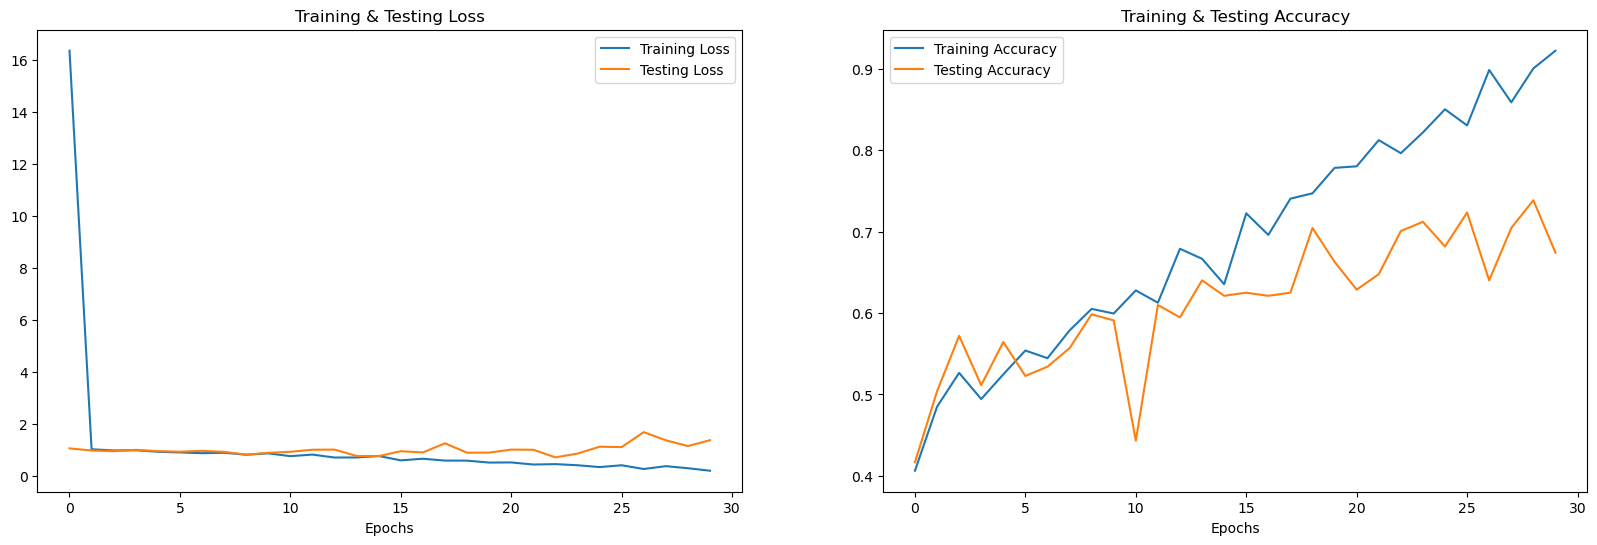

In [31]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

9/9 [==============================] - 0s 13ms/step


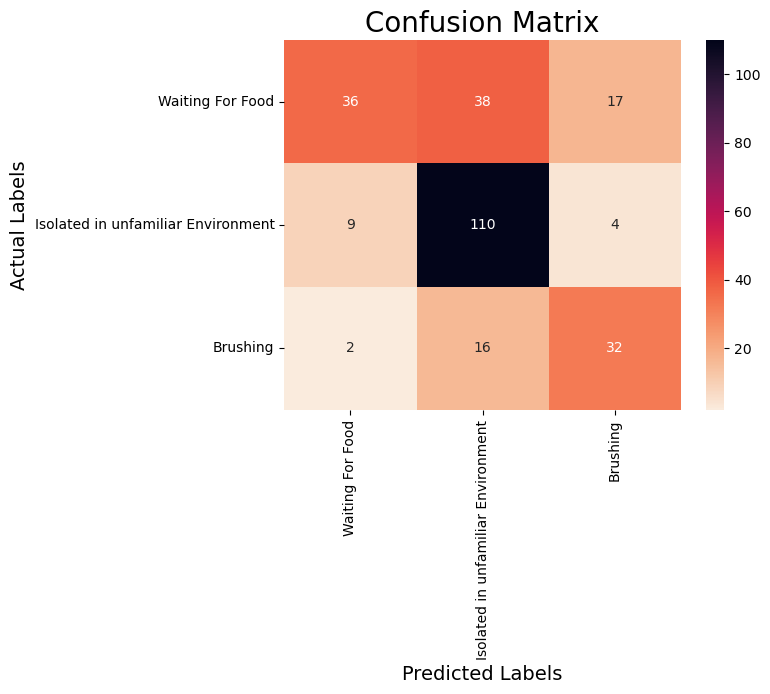

In [32]:
y_pred = model.predict(x_test)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['Waiting For Food', 'Isolated in unfamiliar Environment', 'Brushing'], yticklabels = ['Waiting For Food', 'Isolated in unfamiliar Environment', 'Brushing'])
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [33]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.77      0.40      0.52        91
           1       0.67      0.89      0.77       123
           2       0.60      0.64      0.62        50

    accuracy                           0.67       264
   macro avg       0.68      0.64      0.64       264
weighted avg       0.69      0.67      0.65       264



# Model Training

In [34]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.05, patience=3)
model = models.Sequential()
model.add(layers.Conv1D(256, 3, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(layers.MaxPooling1D((1)))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D((1)))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D((1)))
model.add(layers.Conv1D(1024, 3, activation='relu'))
model.add(layers.MaxPooling1D((1)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer='RMSprop',
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 160, 256)          1024      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 160, 256)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 158, 128)          98432     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 158, 128)         0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 156, 128)          49280     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 156, 128)        

In [35]:
t = time()
history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_data=(x_test, y_test))
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Epoch 1/30
9/9 [==============================] - 4s 145ms/step - loss: 8.5181 - accuracy: 0.4337 - val_loss: 1.0197 - val_accuracy: 0.4659
Epoch 2/30
9/9 [==============================] - 1s 83ms/step - loss: 0.9843 - accuracy: 0.4972 - val_loss: 0.9666 - val_accuracy: 0.4545
Epoch 3/30
9/9 [==============================] - 1s 83ms/step - loss: 1.0048 - accuracy: 0.4934 - val_loss: 0.9238 - val_accuracy: 0.5227
Epoch 4/30
9/9 [==============================] - 1s 83ms/step - loss: 1.0046 - accuracy: 0.5047 - val_loss: 0.9426 - val_accuracy: 0.4886
Epoch 5/30
9/9 [==============================] - 1s 83ms/step - loss: 0.9165 - accuracy: 0.5303 - val_loss: 1.0067 - val_accuracy: 0.4470
Epoch 6/30
9/9 [==============================] - 1s 84ms/step - loss: 0.9054 - accuracy: 0.5312 - val_loss: 0.9226 - val_accuracy: 0.4924
Epoch 7/30
9/9 [==============================] - 1s 84ms/step - loss: 0.9167 - accuracy: 0.5436 - val_loss: 1.0071 - val_accuracy: 0.4886
Epoch 8/30
9/9 [==========

9/9 [==============================] - 0s 8ms/step - loss: 1.0581 - accuracy: 0.7348
Accuracy of our model on test data :  73.48484992980957 %


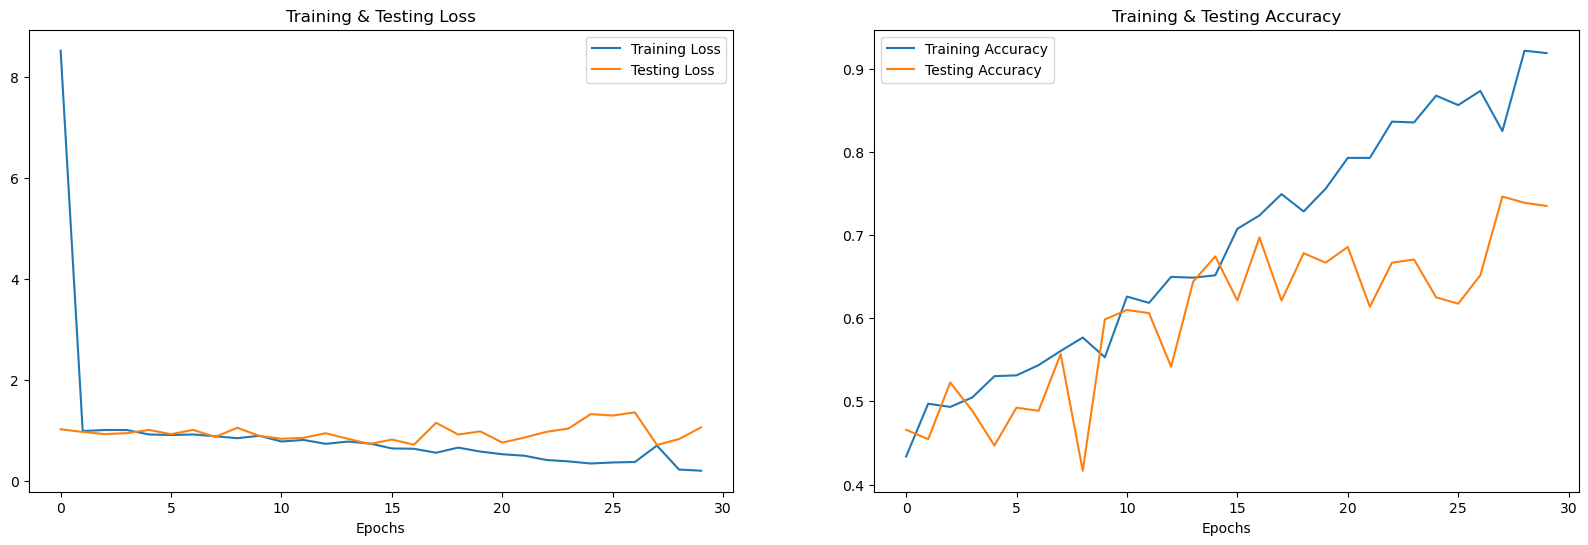

In [36]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

9/9 [==============================] - 0s 6ms/step


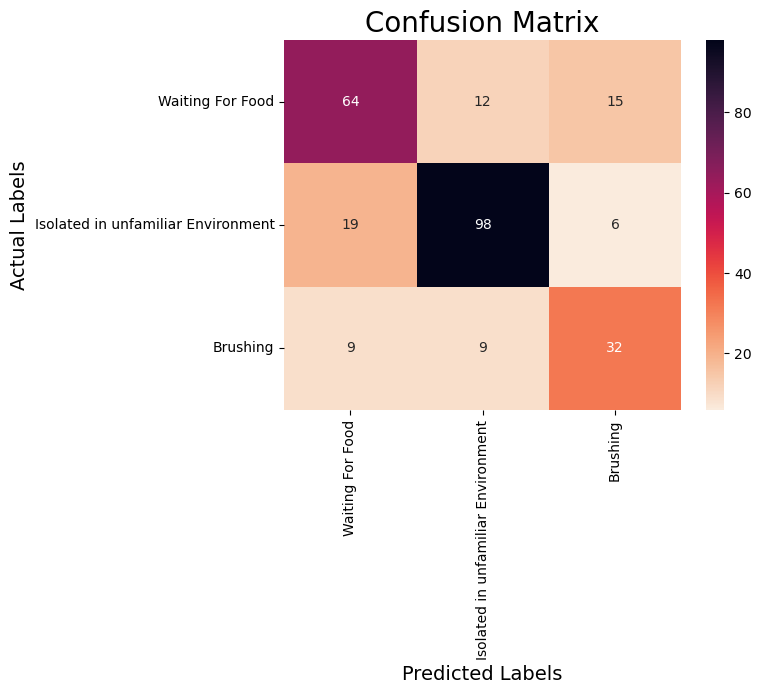

In [37]:
y_pred = model.predict(x_test)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['Waiting For Food', 'Isolated in unfamiliar Environment', 'Brushing'], yticklabels = ['Waiting For Food', 'Isolated in unfamiliar Environment', 'Brushing'])
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [38]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        91
           1       0.82      0.80      0.81       123
           2       0.60      0.64      0.62        50

    accuracy                           0.73       264
   macro avg       0.71      0.71      0.71       264
weighted avg       0.74      0.73      0.74       264

